<a href="https://colab.research.google.com/github/ganeshhep/JETS/blob/main/tutorial5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations

In [1]:
!pip install uproot
!pip install fastjet
!pip install vector

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.4/350.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.9/787.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.9/707.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.7/173.7 kB 19.0 MB/s eta 0:00:00


## Imports

In [2]:
import uproot
import vector
from fastjet import PseudoJet, JetDefinition, ClusterSequence, antikt_algorithm
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
vector.register_awkward()

In [3]:
# Loading the data
from google.colab import drive
drive.mount('/content/drive')
data_file = "/content/drive/MyDrive/tutorial5.root"

Mounted at /content/drive


In [4]:
tree = uproot.open(data_file)["tree"]

In [5]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | int32_t                  | AsDtype('>i4')
size                 | int32_t                  | AsDtype('>i4')
no                   | int32_t                  | AsDtype('>i4')
id                   | int32_t                  | AsDtype('>i4')
charge               | double                   | AsDtype('>f8')
is_charged           | int8_t                   | AsDtype('int8')
is_neutral           | int8_t                   | AsDtype('int8')
may_decay            | int8_t                   | AsDtype('int8')
isLepton             | int8_t                   | AsDtype('int8')
m                    | double                   | AsDtype('>f8')
px                   | double                   | AsDtype('>f8')
py                   | double                   | AsDtype('>f8')
pz                   | double                   | AsDt

In [6]:
tree.num_entries # This is the sum total of number of all the particles obtained at the final state of all the events.

83815921

In [7]:
table = tree.arrays()

In [37]:
n_jets = [] # a list containing number of jets in each event for R = 0.4
m_jets = [] # a list containing number of jets in each event for R = 0.8
jet_pT_1 = [] # a list containing jets pT for R = 0.4
jet_pT_2 = [] # a list containing jets pT for R = 0.8
jet_eta_1 = [] # a list containing jets eta for R = 0.4
jet_eta_2 = [] # a list containing jets eta for R = 0.8
inv_mass = [] # a list containing invariant masses

for event in range(1, 501) : # taking upto 500 events
    arr1 = table["event"] == event

    # In an event, extacting the stable particles with transverse momentum, pT > 1 GeV
    arr2 = table[arr1]
    arr3 = arr2["may_decay"] == 0
    arr4 = arr2[arr3]
    arr5 = arr4["pT"] > 1
    arr6 = arr4[arr5] # arr6 contains all the stable particles with pT > 1 GeV.

    # Collecting the 4-momentum of the particles
    p4 = vector.zip({"px": arr6["px"], "py": arr6["py"], "pz": arr6["pz"], "energy": arr6["e"]})
    array = ak.Array([p4], with_name = "Momentum4D")

    # Applying clustering of particles with anti-kt algorithm
    cluster_1 = ClusterSequence(array, JetDefinition(antikt_algorithm, 0.4))
    cluster_2 = ClusterSequence(array, JetDefinition(antikt_algorithm, 0.8))
    jet_set_1 = cluster_1.inclusive_jets()
    jet_set_2 = cluster_2.inclusive_jets()

    for i in range(len(jet_set_1[0])) :
        # For each i-th jet, jet_ob_1/2 contains px, py, pz and E of the jet.
        jet_ob_1 = PseudoJet(jet_set_1[0][i]['px'], jet_set_1[0][i]['py'], jet_set_1[0][i]['pz'], jet_set_1[0][i]['E'])
        jet_pT_1.append(jet_ob_1.pt())
        jet_eta_1.append(jet_ob_1.eta())

    for j in range(len(jet_set_2[0])) :
        jet_ob_2 = PseudoJet(jet_set_2[0][j]['px'], jet_set_2[0][j]['py'], jet_set_2[0][j]['pz'], jet_set_2[0][j]['E'])
        jet_pT_2.append(jet_ob_2.pt())
        jet_eta_2.append(jet_ob_2.eta())

    n_jets.append(len(jet_set_1[0]))
    m_jets.append(len(jet_set_2[0]))

    # Now we take the events with no leptons.
    # In an event, from all of the obtained jets, we take any two jets, combine them and calculate the invariant mass.
    # This invariant mass is then appended to the list inv_mass. This is done for each event.
    arr7 = arr6["isLepton"]
    if any(arr7) == 0 :
      for k in range(len(jet_set_1[0])) :
        no_lep_jet_1 = PseudoJet(jet_set_1[0][i]['px'], jet_set_1[0][i]['py'], jet_set_1[0][i]['pz'], jet_set_1[0][i]['E'])
        for l in range(len(jet_set_1[0])) :
          no_lep_jet_2 = PseudoJet(jet_set_1[0][l]['px'], jet_set_1[0][l]['py'], jet_set_1[0][l]['pz'], jet_set_1[0][l]['E'])
          if l != k and l > k :
            add_jet = no_lep_jet_1 + no_lep_jet_2
            inv_mass.append(add_jet.m())



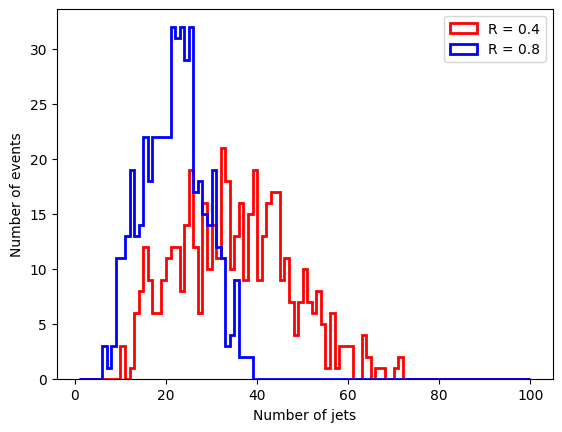

In [38]:
plt.hist(n_jets, bins = np.arange(1, 101), label = 'R = 0.4', color = 'red', histtype = 'step', linewidth = 2.)
plt.hist(m_jets, bins = np.arange(1, 101), label = 'R = 0.8', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("Number of jets")
plt.ylabel("Number of events")
plt.legend()
plt.show()

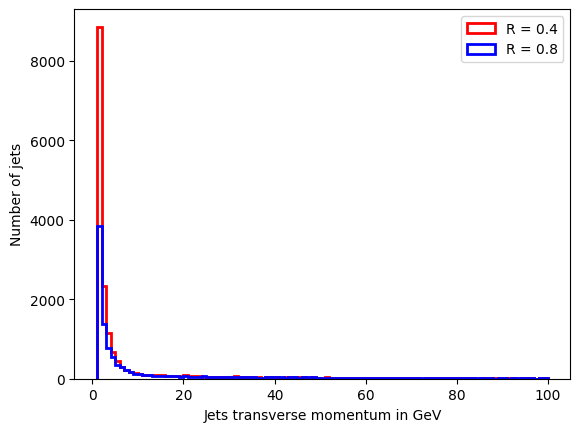

In [39]:
plt.hist(jet_pT_1, bins = np.arange(1, 101), label = 'R = 0.4', color = 'red', histtype = 'step', linewidth = 2.)
plt.hist(jet_pT_2, bins = np.arange(1, 101), label = 'R = 0.8', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("Jets transverse momentum in GeV")
plt.ylabel("Number of jets")
plt.legend()
plt.show()

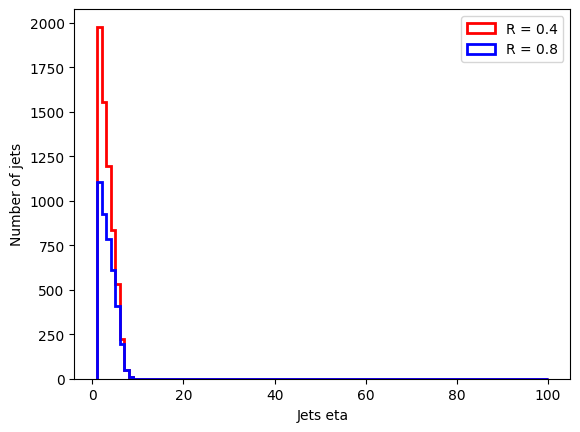

In [40]:
plt.hist(jet_eta_1, bins = np.arange(1, 101), label = 'R = 0.4', color = 'red', histtype = 'step', linewidth = 2.)
plt.hist(jet_eta_2, bins = np.arange(1, 101), label = 'R = 0.8', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("Jets eta")
plt.ylabel("Number of jets")
plt.legend()
plt.show()

Text(0, 0.5, 'Number of paired jets')

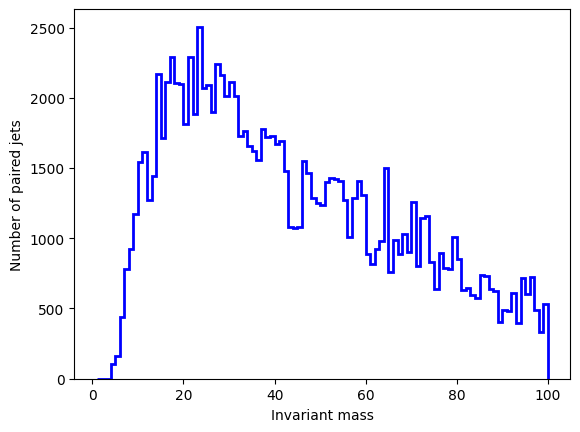

In [41]:
plt.hist(inv_mass, bins = np.arange(1, 101), label = 'R = 0.4', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("Invariant mass")
plt.ylabel("Number of paired jets")